Removing outliers seem largely inconsequential on the skew of the data as the medians tend to hover around 0 for most of the variables. Removing outliers, therefore, does not improve the skew of distributions. A more significant change may be to convert all variables to Binary Variables, given the fact that there are many 0 values in each variable any way. Based on the predictor of whether the certain type of crime occurs, or not, we may be able to gain more insight on predicting Murder.

Making all variables binary seem to result in incredibly inconsistent Rsquared values when testing on holdout groups however they score at nearly 99% on the test sample. This seems to be a sign of overfitting. Perhaps making some of the variables binary and leaving some as continuous will improve the consistency.

My thoughts for creating relevant features is to...:
1. First explore the data and decide which variables should be converted into binary variables
2. Inverse code new variables such as "safe" variables as opposed to crime variables
3. Combine variables that are highly correlated
4. Second create log transformations on the continious predictor variables that I already have so that I can normalize the data.
5. Remove outliers by a facor of the the third quartile + 3 * the interquartile range

Model predictions are still inconsistent. From here on try:
1. Creating proper inverse variables that aren't endogonious
2. Revert some of the binary features back to conintious, apply a log transformation and remove outliers
3. If model results are still highly inconcistent, combine other correlated variables.
4. If model is still inconsistent, try creating PCAs with all variables that correlate above 90%

In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Data Cleaning
# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Rape'] = df['Rape (legacy definition)']
df = df.drop(columns=['Rape (legacy definition)'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

df['MotorVehicleTheft'] = df['Motor Vehicle Theft']
df = df.drop(columns=['Motor Vehicle Theft'])

In [6]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
0,Adams Village,1861,0,0,0,2,10,12,0,0,0
1,Addison Town and Village,2577,3,0,0,3,20,24,0,3,1
2,Akron Village,2846,3,0,0,1,15,16,0,3,0
3,Albany,97956,791,8,227,705,3243,4090,30,526,142
4,Albion Village,6388,23,0,4,53,165,223,3,16,5


In [7]:
df.corr()

,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
Population,1.000,0.999,0.987,0.998,0.971,0.998,0.996,0.991,0.999,0.992
Violent Crime,0.999,1.000,0.992,1.000,0.978,0.999,0.998,0.995,1.000,0.996
Murder,0.987,0.992,1.000,0.993,0.994,0.993,0.995,0.998,0.991,0.998
Robbery,0.998,1.000,0.993,1.000,0.980,0.999,0.998,0.995,1.000,0.997
Burglary,0.971,0.978,0.994,0.980,1.000,0.983,0.987,0.992,0.976,0.991
Larceny-Theft,0.998,0.999,0.993,0.999,0.983,1.000,1.000,0.996,0.999,0.997
Propertycrime,0.996,0.998,0.995,0.998,0.987,1.000,1.000,0.998,0.998,0.998
Rape,0.991,0.995,0.998,0.995,0.992,0.996,0.998,1.000,0.994,0.999
Aggravated_Assault,0.999,1.000,0.991,1.000,0.976,0.999,0.998,0.994,1.000,0.995
MotorVehicleTheft,0.992,0.996,0.998,0.997,0.991,0.997,0.998,0.999,0.995,1.000


In [8]:
df.describe()

,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,72.902,119.684,637.017,792.606,5.865,121.261,35.905
std,450037.368,2815.269,18.304,1031.033,924.949,6346.054,7659.725,60.425,1706.132,403.424
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,6.000,31.000,40.500,0.000,1.000,0.000
50%,7233.500,6.000,0.000,1.000,17.500,94.000,112.500,0.000,4.000,2.000
75%,18427.500,22.000,0.000,5.000,51.250,287.250,341.000,2.000,14.000,7.000
max,8396126.000,52384.000,335.000,19170.000,16606.000,117931.000,141971.000,1112.000,31767.000,7434.000


Variables to convert to Binary:

1. Robbery
2. Moto Vehicle theft
3. Rape
4. Aggravated_Assault
4. Violent Crime
5. Murder

In [9]:
# Combine aggravated assault and violent crime because of its incredibly high correlation

means = df[['Violent Crime', 'Aggravated_Assault']].mean(axis=0)
stds = df[['Violent Crime', 'Aggravated_Assault']].std(axis=0)
df['Violent_Aggravated_Assault'] = ((df[['Violent Crime', 'Aggravated_Assault']] - means)/stds).mean(axis=1)

In [10]:
# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
df['Aggravated_Assault'] = np.where(df['Aggravated_Assault']>0, '1', '0')
df['Violent Crime'] = np.where(df['Violent Crime']>0, '1', '0')
df['Rape'] = np.where(df['Rape']>0, '1', '0')
df['Robbery'] = np.where(df['Robbery']>0, '1', '0')
df['MotorVehicleTheft'] = np.where(df['MotorVehicleTheft']>0, '1', '0')


#Convert new columns to int
df[['Population', 'Violent Crime',
       'Murder', 'Rape',
       'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'MotorVehicleTheft']] = df[['Population', 'Violent Crime',
       'Murder', 'Rape', 'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'MotorVehicleTheft']].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 347
Data columns (total 13 columns):
City                          348 non-null object
Population                    348 non-null int64
Violent Crime                 348 non-null int64
Murder                        348 non-null int64
Robbery                       348 non-null int64
Burglary                      348 non-null int64
Larceny-Theft                 348 non-null int64
Propertycrime                 348 non-null int64
Rape                          348 non-null int64
Aggravated_Assault            348 non-null int64
MotorVehicleTheft             348 non-null int64
Violent_Aggravated_Assault    348 non-null float64
Population^2                  348 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 38.1+ KB


In [12]:
# Code safety variable:

# Safeproperty variable:

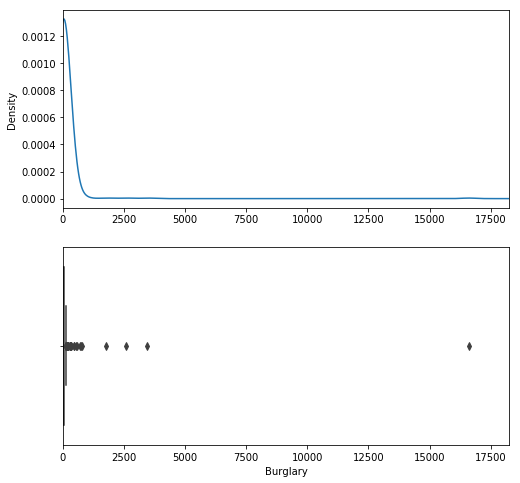

In [13]:
i = 'Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [14]:
# Remove any zeros (otherwise we get (-inf)
df.loc[df.Burglary == 0, 'Burglary'] = np.nan

# Drop Na
df.dropna(inplace=True)

# Log Transformation
df['log_' + i] = np.log(df[i])

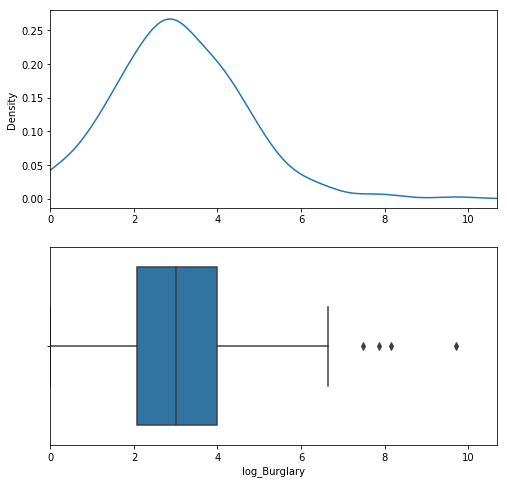

In [15]:
i = 'log_Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [16]:
q75,q25 = np.percentile(df.log_Burglary.dropna(), [75,25])
iqr = q75 - q25

min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

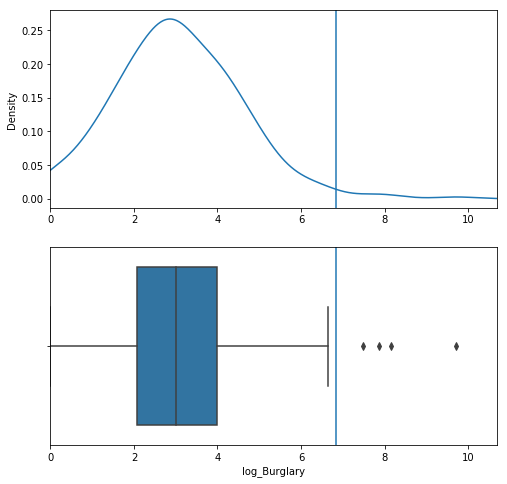

In [17]:
i = 'log_Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [18]:
df['Outliers'] = 0

df.loc[df[i] < min, 'Outliers'] = 1
df.loc[df[i] > max, 'Outliers'] = 1

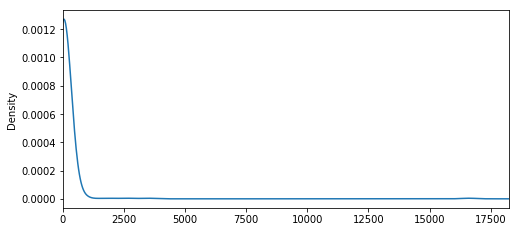

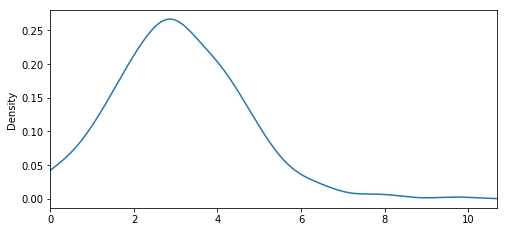

In [19]:
i = 'Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

i = 'log_Burglary'
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

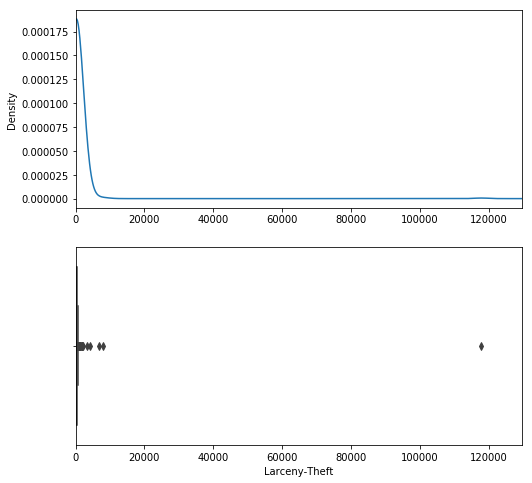

In [20]:
i = 'Larceny-Theft'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [21]:
# Remove any zeros (otherwise we get (-inf)
df.loc[df['Larceny-Theft'] == 0, 'Larceny-Theft'] = np.nan

# Drop Na
df.dropna(inplace=True)

# Log Transformation
df['log_' + i] = np.log(df[i])

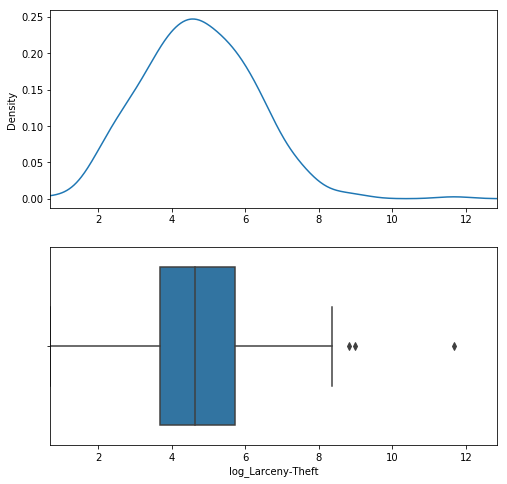

In [22]:
i = 'log_Larceny-Theft'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [23]:
q75,q25 = np.percentile(df['log_Larceny-Theft'].dropna(), [75,25])
iqr = q75 - q25

min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

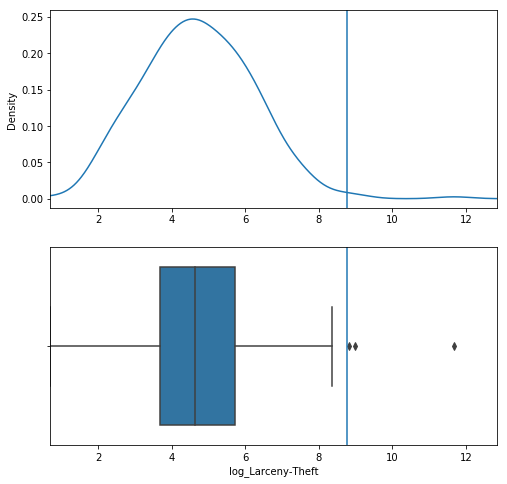

In [24]:
i = 'log_Larceny-Theft'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [25]:
df['Outliers'] = 0

df.loc[df[i] < min, 'Outliers'] = 1
df.loc[df[i] > max, 'Outliers'] = 1

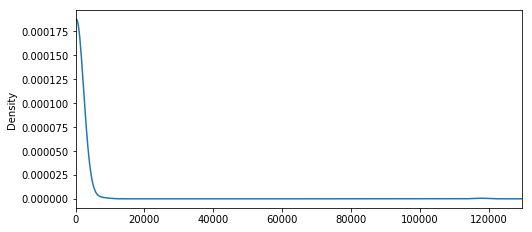

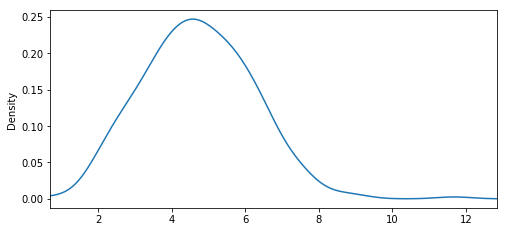

In [26]:
i = 'Larceny-Theft'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

i = 'log_Larceny-Theft'
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

In [27]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft,Violent_Aggravated_Assault,Population^2,log_Burglary,Outliers,log_Larceny-Theft
0,Adams Village,1861,0,0,0,2.000,10.000,12,0,0,0,-0.071,3463321,0.693,0,2.303
1,Addison Town and Village,2577,1,0,0,3.000,20.000,24,0,1,1,-0.070,6640929,1.099,0,2.996
2,Akron Village,2846,1,0,0,1.000,15.000,16,0,1,0,-0.070,8099716,0.000,0,2.708
3,Albany,97956,1,1,1,705.000,3243.000,4090,1,1,1,0.223,9595377936,6.558,0,8.084
4,Albion Village,6388,1,0,1,53.000,165.000,223,1,1,1,-0.063,40806544,3.970,0,5.106


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 0 to 347
Data columns (total 16 columns):
City                          326 non-null object
Population                    326 non-null int64
Violent Crime                 326 non-null int64
Murder                        326 non-null int64
Robbery                       326 non-null int64
Burglary                      326 non-null float64
Larceny-Theft                 326 non-null float64
Propertycrime                 326 non-null int64
Rape                          326 non-null int64
Aggravated_Assault            326 non-null int64
MotorVehicleTheft             326 non-null int64
Violent_Aggravated_Assault    326 non-null float64
Population^2                  326 non-null int64
log_Burglary                  326 non-null float64
Outliers                      326 non-null int64
log_Larceny-Theft             326 non-null float64
dtypes: float64(5), int64(10), object(1)
memory usage: 43.3+ KB


In [29]:
# Compile Features
features = pd.DataFrame()
features = df.drop(columns=['City', 'Population', 'Burglary', 'Larceny-Theft', 'Outliers', 'Aggravated_Assault', 'Violent Crime'])
features = features.rename(index=str, columns={'Population^2': 'Population_squared', 'log_Larceny-Theft': 'log_LarcenyTheft'})
features.head()

,Murder,Robbery,Propertycrime,Rape,MotorVehicleTheft,Violent_Aggravated_Assault,Population_squared,log_Burglary,log_LarcenyTheft
0,0,0,12,0,0,-0.071,3463321,0.693,2.303
1,0,0,24,0,1,-0.070,6640929,1.099,2.996
2,0,0,16,0,0,-0.070,8099716,0.000,2.708
3,1,1,4090,1,1,0.223,9595377936,6.558,8.084
4,0,1,223,1,1,-0.063,40806544,3.970,5.106


In [30]:
features.corr()

,Murder,Robbery,Propertycrime,Rape,MotorVehicleTheft,Violent_Aggravated_Assault,Population_squared,log_Burglary,log_LarcenyTheft
Murder,1.000,0.299,0.189,0.369,0.207,0.164,0.132,0.530,0.495
Robbery,0.299,1.000,0.075,0.439,0.399,0.055,0.042,0.594,0.656
Propertycrime,0.189,0.075,1.000,0.104,0.053,0.998,0.991,0.322,0.329
Rape,0.369,0.439,0.104,1.000,0.231,0.081,0.063,0.622,0.615
MotorVehicleTheft,0.207,0.399,0.053,0.231,1.000,0.039,0.030,0.439,0.471
Violent_Aggravated_Assault,0.164,0.055,0.998,0.081,0.039,1.000,0.997,0.281,0.288
Population_squared,0.132,0.042,0.991,0.063,0.030,0.997,1.000,0.244,0.256
log_Burglary,0.530,0.594,0.322,0.622,0.439,0.281,0.244,1.000,0.920
log_LarcenyTheft,0.495,0.656,0.329,0.615,0.471,0.288,0.256,0.920,1.000


In [31]:
# Run Model
regr = linear_model.LinearRegression()
y = features['Propertycrime'].values.reshape(-1, 1)
x = features.drop(columns=['Propertycrime'])
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[-5.19255261e+01 -1.09882790e+02 -5.97963093e+01 -7.92818873e+01
   1.09637023e+04 -9.02984214e-10  3.66887051e+00  2.07869601e+02]]

Intercept: 
 [164.48515695]

R-squared:
 0.998763784952821


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [32]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: -4236.3999787158255
Testing on sample:0.998763784952821


In [33]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

array([  0.96230677,   0.65186213,   0.42294508, -27.96691605,
         0.87131295])

In [34]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 0 to 347
Data columns (total 9 columns):
Murder                        326 non-null int64
Robbery                       326 non-null int64
Propertycrime                 326 non-null int64
Rape                          326 non-null int64
MotorVehicleTheft             326 non-null int64
Violent_Aggravated_Assault    326 non-null float64
Population_squared            326 non-null int64
log_Burglary                  326 non-null float64
log_LarcenyTheft              326 non-null float64
dtypes: float64(3), int64(6)
memory usage: 25.5+ KB


In [35]:
# Test for significance in parameters
linear_formula = 'Propertycrime ~ Population_squared+Murder+Rape+MotorVehicleTheft+log_Burglary+Robbery+Violent_Aggravated_Assault+log_LarcenyTheft'

# Fit the model to our data using formula
lm = smf.ols(formula=linear_formula, data=features).fit()

In [36]:
lm.params

Intercept                      164.446
Population_squared              -0.000
Murder                         -51.928
Rape                           -59.796
MotorVehicleTheft              -79.282
log_Burglary                     3.669
Robbery                       -109.883
Violent_Aggravated_Assault   10963.704
log_LarcenyTheft               207.870
dtype: float64

In [37]:
lm.pvalues

Intercept                    0.028
Population_squared           0.000
Murder                       0.326
Rape                         0.151
MotorVehicleTheft            0.068
log_Burglary                 0.897
Robbery                      0.015
Violent_Aggravated_Assault   0.000
log_LarcenyTheft             0.000
dtype: float64